# DCGAN on Bricks Dataset

In [1]:
import os
from collections import defaultdict
from PIL import Image
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary
from torcheval import metrics as Metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 300
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1),
                            Transforms.Normalize((0.5), (0.5))])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    print('Train data size: ', len(lego_dataset))
    print('Num. train batchs: ', len(train_loader))
    return train_loader

In [5]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

Train data size:  40000
Num. train batchs:  313
torch.Size([128, 1, 64, 64])


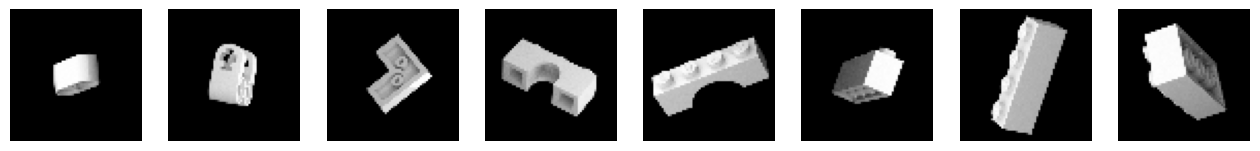

In [6]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)

# test = Discriminator().to(DEVICE)
# summary(test, (1, 64, 64))

In [8]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x

    
    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

# generator = Generator(Z_DIM).to(DEVICE)
# summary(generator, (100,))

In [9]:
# class DCGAN(nn.Module):
    
#     def __init__(self, z_dim):
#         super().__init__()
#         self.z_dim = z_dim
#         self.generator = Generator(z_dim)
#         self.discriminator = Discriminator()


#     def forward(self, real_imgs):
#         latents = torch.randn(size=(len(real_imgs), self.z_dim)).to(DEVICE)
#         generated_imgs = self.generator(latents)

#         real_preds = self.discriminator(real_imgs)
#         fake_preds = self.discriminator(generated_imgs)
        
#         return real_preds, fake_preds, generated_imgs

# dcgan = DCGAN(Z_DIM).to(DEVICE)
# summary(dcgan, (1, 64, 64))

## 3. Define the model, objective, and optimizer

In [10]:
net_D = Discriminator().to(DEVICE)
net_G = Generator(Z_DIM).to(DEVICE)


if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    net_D = torch.compile(net_D, backend='eager')
    net_G = torch.compile(net_G, backend='eager')
    print('model compiled')

loss_fn = nn.BCELoss()
d_optim = torch.optim.Adam(params=net_D.parameters(), lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=net_G.parameters() ,lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))

train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
    'd_real_acc': Metrics.BinaryAccuracy(),
    'd_fake_acc': Metrics.BinaryAccuracy(),
    'g_acc': Metrics.BinaryAccuracy(),
}

model compiled


## 4. Get dataloader

In [11]:
lego_dataloader = get_dataloader()

Train data size:  40000
Num. train batchs:  313


## 5. Train step function

In [12]:
def train(net_D, net_G, dataloader, d_optim, g_optim, loss_fn, train_metrics):
    
    net_D.train() # Set model to train mode
    net_G.train()
    
    for metric in train_metrics.values():
        metric.reset() # clear metrics data

    for i, train_imgs in enumerate(dataloader):

        # 1. Update Discriminator
        
        # Train with real data
        net_D.zero_grad()

        train_imgs = train_imgs.to(DEVICE)
        real_pred = net_D(train_imgs)
        real_label = torch.ones_like(real_pred, dtype=torch.float)
        real_noisy_label = real_label + NOISE_PARAM * torch.randn(size=real_label.shape, device=DEVICE)

        d_real_loss = loss_fn(real_pred.reshape(-1), real_noisy_label.reshape(-1))
        d_real_loss.backward(retain_graph=True)

        # Generate fake batch
        noise = torch.randn(size=(len(train_imgs), Z_DIM), device=DEVICE)
        fake_imgs = net_G(noise)
        fake_pred = net_D(fake_imgs)
        fake_label = torch.zeros_like(fake_pred, dtype=torch.float)
        fake_noisy_label = fake_label - NOISE_PARAM * torch.randn(size=fake_label.shape, device=DEVICE)

        d_fake_loss = loss_fn(fake_pred.reshape(-1), fake_noisy_label.reshape(-1))
        d_fake_loss.backward(retain_graph=True)

        d_loss = d_fake_loss + d_real_loss
        d_optim.step()


        # 2. Update Generator
        net_G.zero_grad()
        fake_pred = net_D(fake_imgs)
        g_loss = loss_fn(fake_pred.reshape(-1), real_label.reshape(-1))

        g_loss.backward()
        g_optim.step()
    
        # Update metrics
        train_metrics['d_loss'].update(d_loss.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['d_fake_acc'].update(fake_pred.reshape(-1).detach().cpu(), fake_label.reshape(-1).detach().cpu())
        train_metrics['d_real_acc'].update(real_pred.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())
        train_metrics['g_acc'].update(fake_pred.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())

        del d_loss, g_loss, fake_pred, real_pred, real_label, real_noisy_label, fake_label, fake_noisy_label 

    return fake_imgs

## 6. Train DCGAN

Epoch: 1	epoch time 0.39 min
	 d_loss: 0.3410 | g_loss: 9.6574 | d_real_acc: 0.9216 | d_fake_acc: 0.9774 | g_acc: 0.0226 | 


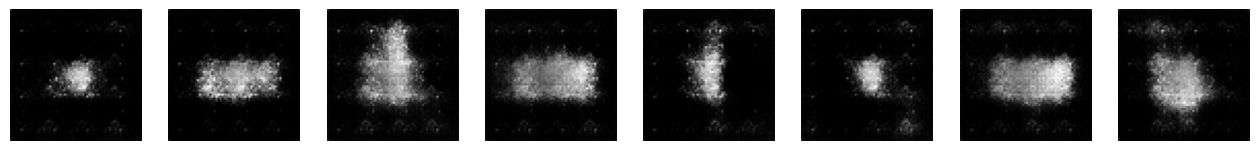

Epoch: 2	epoch time 0.37 min
	 d_loss: 1.0580 | g_loss: 1.8805 | d_real_acc: 0.7330 | d_fake_acc: 0.8971 | g_acc: 0.1029 | 
Epoch: 3	epoch time 0.37 min
	 d_loss: 0.9586 | g_loss: 2.0575 | d_real_acc: 0.7725 | d_fake_acc: 0.9020 | g_acc: 0.0980 | 
Epoch: 4	epoch time 0.37 min
	 d_loss: 0.9474 | g_loss: 2.0335 | d_real_acc: 0.7746 | d_fake_acc: 0.8825 | g_acc: 0.1175 | 
Epoch: 5	epoch time 0.37 min
	 d_loss: 0.8152 | g_loss: 2.2613 | d_real_acc: 0.8161 | d_fake_acc: 0.9131 | g_acc: 0.0869 | 
Epoch: 6	epoch time 0.37 min
	 d_loss: 0.7479 | g_loss: 2.3870 | d_real_acc: 0.8346 | d_fake_acc: 0.9185 | g_acc: 0.0815 | 
Epoch: 7	epoch time 0.37 min
	 d_loss: 0.7090 | g_loss: 2.4663 | d_real_acc: 0.8454 | d_fake_acc: 0.9100 | g_acc: 0.0900 | 
Epoch: 8	epoch time 0.37 min
	 d_loss: 0.6900 | g_loss: 2.5721 | d_real_acc: 0.8471 | d_fake_acc: 0.9233 | g_acc: 0.0767 | 
Epoch: 9	epoch time 0.37 min
	 d_loss: 0.6293 | g_loss: 2.7420 | d_real_acc: 0.8698 | d_fake_acc: 0.9278 | g_acc: 0.0722 | 
Epoch: 1

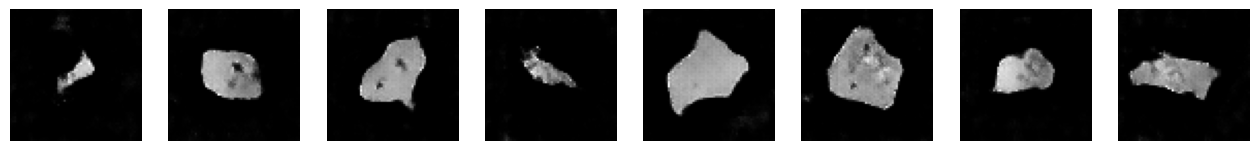

Epoch: 11	epoch time 0.37 min
	 d_loss: 0.5551 | g_loss: 2.9519 | d_real_acc: 0.8842 | d_fake_acc: 0.9300 | g_acc: 0.0700 | 
Epoch: 12	epoch time 0.37 min
	 d_loss: 0.5682 | g_loss: 3.0444 | d_real_acc: 0.8841 | d_fake_acc: 0.9329 | g_acc: 0.0671 | 
Epoch: 13	epoch time 0.38 min
	 d_loss: 0.5532 | g_loss: 3.1282 | d_real_acc: 0.8878 | d_fake_acc: 0.9366 | g_acc: 0.0634 | 
Epoch: 14	epoch time 0.37 min
	 d_loss: 0.5180 | g_loss: 3.3109 | d_real_acc: 0.8960 | d_fake_acc: 0.9419 | g_acc: 0.0581 | 
Epoch: 15	epoch time 0.37 min
	 d_loss: 0.5409 | g_loss: 3.1965 | d_real_acc: 0.8887 | d_fake_acc: 0.9322 | g_acc: 0.0678 | 
Epoch: 16	epoch time 0.37 min
	 d_loss: 0.4893 | g_loss: 3.3036 | d_real_acc: 0.9051 | d_fake_acc: 0.9392 | g_acc: 0.0608 | 
Epoch: 17	epoch time 0.37 min
	 d_loss: 0.4494 | g_loss: 3.4825 | d_real_acc: 0.9126 | d_fake_acc: 0.9388 | g_acc: 0.0612 | 
Epoch: 18	epoch time 0.37 min
	 d_loss: 0.4734 | g_loss: 3.5131 | d_real_acc: 0.9107 | d_fake_acc: 0.9424 | g_acc: 0.0576 | 


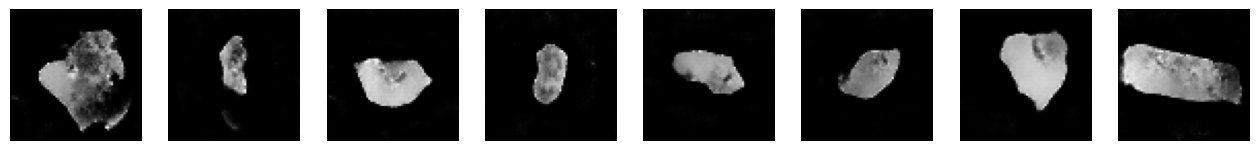

Epoch: 21	epoch time 0.37 min
	 d_loss: 0.4318 | g_loss: 3.6991 | d_real_acc: 0.9179 | d_fake_acc: 0.9441 | g_acc: 0.0560 | 
Epoch: 22	epoch time 0.37 min
	 d_loss: 0.4408 | g_loss: 3.6985 | d_real_acc: 0.9180 | d_fake_acc: 0.9452 | g_acc: 0.0549 | 
Epoch: 23	epoch time 0.38 min
	 d_loss: 0.4152 | g_loss: 3.6418 | d_real_acc: 0.9170 | d_fake_acc: 0.9370 | g_acc: 0.0630 | 
Epoch: 24	epoch time 0.37 min
	 d_loss: 0.4173 | g_loss: 3.8327 | d_real_acc: 0.9183 | d_fake_acc: 0.9408 | g_acc: 0.0592 | 
Epoch: 25	epoch time 0.37 min
	 d_loss: 0.3959 | g_loss: 3.8801 | d_real_acc: 0.9262 | d_fake_acc: 0.9485 | g_acc: 0.0515 | 
Epoch: 26	epoch time 0.37 min
	 d_loss: 0.4122 | g_loss: 3.9536 | d_real_acc: 0.9207 | d_fake_acc: 0.9421 | g_acc: 0.0579 | 
Epoch: 27	epoch time 0.37 min
	 d_loss: 0.3892 | g_loss: 3.9258 | d_real_acc: 0.9231 | d_fake_acc: 0.9487 | g_acc: 0.0513 | 
Epoch: 28	epoch time 0.37 min
	 d_loss: 0.3386 | g_loss: 4.2125 | d_real_acc: 0.9348 | d_fake_acc: 0.9577 | g_acc: 0.0424 | 


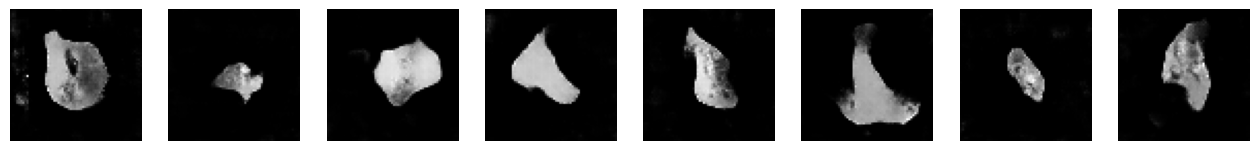

Epoch: 31	epoch time 0.36 min
	 d_loss: 0.3854 | g_loss: 4.1276 | d_real_acc: 0.9282 | d_fake_acc: 0.9449 | g_acc: 0.0551 | 
Epoch: 32	epoch time 0.37 min
	 d_loss: 0.3523 | g_loss: 4.1344 | d_real_acc: 0.9323 | d_fake_acc: 0.9462 | g_acc: 0.0538 | 
Epoch: 33	epoch time 0.37 min
	 d_loss: 0.3659 | g_loss: 4.2174 | d_real_acc: 0.9311 | d_fake_acc: 0.9477 | g_acc: 0.0523 | 
Epoch: 34	epoch time 0.36 min
	 d_loss: 0.3254 | g_loss: 4.2950 | d_real_acc: 0.9397 | d_fake_acc: 0.9578 | g_acc: 0.0422 | 
Epoch: 35	epoch time 0.36 min
	 d_loss: 0.3717 | g_loss: 4.1741 | d_real_acc: 0.9261 | d_fake_acc: 0.9399 | g_acc: 0.0601 | 
Epoch: 36	epoch time 0.37 min
	 d_loss: 0.3033 | g_loss: 4.4280 | d_real_acc: 0.9438 | d_fake_acc: 0.9536 | g_acc: 0.0464 | 
Epoch: 37	epoch time 0.37 min
	 d_loss: 0.3650 | g_loss: 4.3760 | d_real_acc: 0.9319 | d_fake_acc: 0.9430 | g_acc: 0.0570 | 
Epoch: 38	epoch time 0.37 min
	 d_loss: 0.0531 | g_loss: 7.0765 | d_real_acc: 0.9920 | d_fake_acc: 0.9950 | g_acc: 0.0050 | 


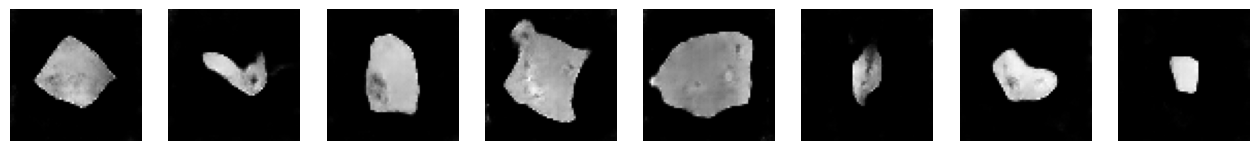

Epoch: 41	epoch time 0.37 min
	 d_loss: 0.3350 | g_loss: 4.5358 | d_real_acc: 0.9383 | d_fake_acc: 0.9517 | g_acc: 0.0483 | 
Epoch: 42	epoch time 0.37 min
	 d_loss: 0.3792 | g_loss: 4.5065 | d_real_acc: 0.9304 | d_fake_acc: 0.9492 | g_acc: 0.0509 | 
Epoch: 43	epoch time 0.37 min
	 d_loss: 0.3109 | g_loss: 4.4427 | d_real_acc: 0.9408 | d_fake_acc: 0.9520 | g_acc: 0.0479 | 
Epoch: 44	epoch time 0.37 min
	 d_loss: 0.3432 | g_loss: 4.5267 | d_real_acc: 0.9347 | d_fake_acc: 0.9556 | g_acc: 0.0444 | 
Epoch: 45	epoch time 0.37 min
	 d_loss: 0.3440 | g_loss: 4.4713 | d_real_acc: 0.9346 | d_fake_acc: 0.9501 | g_acc: 0.0499 | 
Epoch: 46	epoch time 0.37 min
	 d_loss: 0.3516 | g_loss: 4.4291 | d_real_acc: 0.9354 | d_fake_acc: 0.9463 | g_acc: 0.0537 | 
Epoch: 47	epoch time 0.37 min
	 d_loss: 0.3289 | g_loss: 4.5683 | d_real_acc: 0.9376 | d_fake_acc: 0.9571 | g_acc: 0.0429 | 
Epoch: 48	epoch time 0.37 min
	 d_loss: 0.3187 | g_loss: 4.5287 | d_real_acc: 0.9421 | d_fake_acc: 0.9532 | g_acc: 0.0468 | 


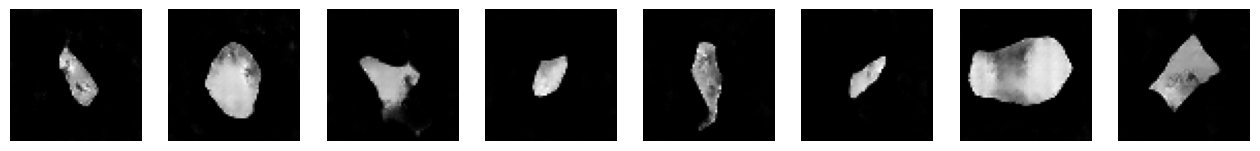

Epoch: 51	epoch time 0.37 min
	 d_loss: 0.3575 | g_loss: 4.4101 | d_real_acc: 0.9314 | d_fake_acc: 0.9421 | g_acc: 0.0578 | 
Epoch: 52	epoch time 0.38 min
	 d_loss: 0.3284 | g_loss: 4.6671 | d_real_acc: 0.9380 | d_fake_acc: 0.9503 | g_acc: 0.0497 | 
Epoch: 53	epoch time 0.37 min
	 d_loss: 0.3023 | g_loss: 4.6071 | d_real_acc: 0.9430 | d_fake_acc: 0.9576 | g_acc: 0.0424 | 
Epoch: 54	epoch time 0.37 min
	 d_loss: 0.3243 | g_loss: 4.7402 | d_real_acc: 0.9402 | d_fake_acc: 0.9577 | g_acc: 0.0423 | 
Epoch: 55	epoch time 0.38 min
	 d_loss: 0.3077 | g_loss: 4.4517 | d_real_acc: 0.9441 | d_fake_acc: 0.9528 | g_acc: 0.0472 | 
Epoch: 56	epoch time 0.38 min
	 d_loss: 0.3313 | g_loss: 4.6145 | d_real_acc: 0.9400 | d_fake_acc: 0.9459 | g_acc: 0.0541 | 
Epoch: 57	epoch time 0.37 min
	 d_loss: 0.3135 | g_loss: 4.7187 | d_real_acc: 0.9438 | d_fake_acc: 0.9531 | g_acc: 0.0468 | 
Epoch: 58	epoch time 0.37 min
	 d_loss: 0.2637 | g_loss: 4.7591 | d_real_acc: 0.9520 | d_fake_acc: 0.9600 | g_acc: 0.0400 | 


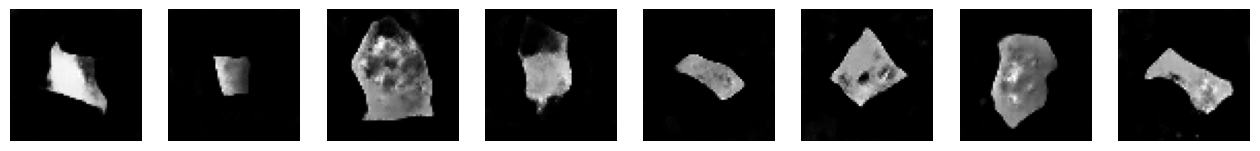

Epoch: 61	epoch time 0.36 min
	 d_loss: 0.3328 | g_loss: 4.6829 | d_real_acc: 0.9390 | d_fake_acc: 0.9537 | g_acc: 0.0463 | 
Epoch: 62	epoch time 0.36 min
	 d_loss: 0.3249 | g_loss: 4.6775 | d_real_acc: 0.9374 | d_fake_acc: 0.9474 | g_acc: 0.0526 | 
Epoch: 63	epoch time 0.35 min
	 d_loss: 0.3084 | g_loss: 4.8022 | d_real_acc: 0.9435 | d_fake_acc: 0.9583 | g_acc: 0.0417 | 
Epoch: 64	epoch time 0.36 min
	 d_loss: 0.3137 | g_loss: 4.7312 | d_real_acc: 0.9402 | d_fake_acc: 0.9481 | g_acc: 0.0518 | 
Epoch: 65	epoch time 0.36 min
	 d_loss: 0.2915 | g_loss: 4.7237 | d_real_acc: 0.9474 | d_fake_acc: 0.9603 | g_acc: 0.0397 | 
Epoch: 66	epoch time 0.37 min
	 d_loss: 0.2851 | g_loss: 4.8500 | d_real_acc: 0.9462 | d_fake_acc: 0.9639 | g_acc: 0.0361 | 
Epoch: 67	epoch time 0.37 min
	 d_loss: 0.3106 | g_loss: 4.8801 | d_real_acc: 0.9423 | d_fake_acc: 0.9524 | g_acc: 0.0476 | 
Epoch: 68	epoch time 0.37 min
	 d_loss: 0.2989 | g_loss: 4.8338 | d_real_acc: 0.9458 | d_fake_acc: 0.9581 | g_acc: 0.0419 | 


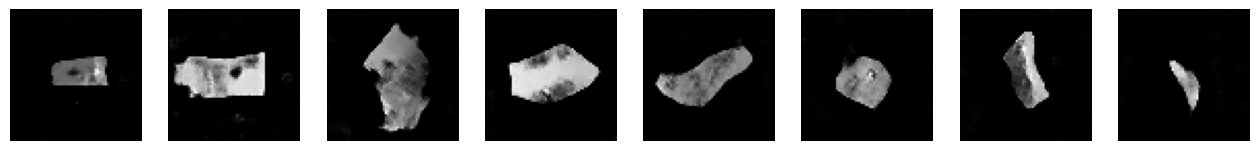

Epoch: 71	epoch time 0.37 min
	 d_loss: 0.2527 | g_loss: 4.9435 | d_real_acc: 0.9548 | d_fake_acc: 0.9620 | g_acc: 0.0380 | 
Epoch: 72	epoch time 0.36 min
	 d_loss: 0.3700 | g_loss: 4.8063 | d_real_acc: 0.9294 | d_fake_acc: 0.9460 | g_acc: 0.0540 | 
Epoch: 73	epoch time 0.37 min
	 d_loss: 0.2642 | g_loss: 4.8911 | d_real_acc: 0.9507 | d_fake_acc: 0.9566 | g_acc: 0.0434 | 
Epoch: 74	epoch time 0.37 min
	 d_loss: 0.2814 | g_loss: 4.9112 | d_real_acc: 0.9502 | d_fake_acc: 0.9620 | g_acc: 0.0380 | 
Epoch: 75	epoch time 0.36 min
	 d_loss: 0.3157 | g_loss: 4.9412 | d_real_acc: 0.9378 | d_fake_acc: 0.9481 | g_acc: 0.0520 | 
Epoch: 76	epoch time 0.36 min
	 d_loss: 0.2794 | g_loss: 5.0491 | d_real_acc: 0.9462 | d_fake_acc: 0.9539 | g_acc: 0.0461 | 
Epoch: 77	epoch time 0.36 min
	 d_loss: 0.3125 | g_loss: 4.8713 | d_real_acc: 0.9417 | d_fake_acc: 0.9534 | g_acc: 0.0466 | 
Epoch: 78	epoch time 0.36 min
	 d_loss: 0.3357 | g_loss: 4.8917 | d_real_acc: 0.9363 | d_fake_acc: 0.9507 | g_acc: 0.0492 | 


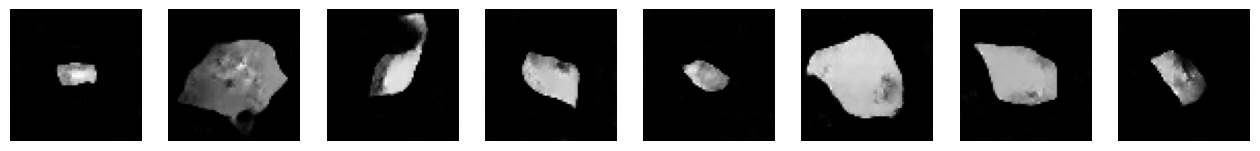

Epoch: 81	epoch time 0.37 min
	 d_loss: 0.2860 | g_loss: 4.9551 | d_real_acc: 0.9459 | d_fake_acc: 0.9594 | g_acc: 0.0406 | 
Epoch: 82	epoch time 0.37 min
	 d_loss: 0.2533 | g_loss: 5.0674 | d_real_acc: 0.9551 | d_fake_acc: 0.9637 | g_acc: 0.0363 | 
Epoch: 83	epoch time 0.37 min
	 d_loss: 0.2833 | g_loss: 4.9805 | d_real_acc: 0.9485 | d_fake_acc: 0.9546 | g_acc: 0.0454 | 
Epoch: 84	epoch time 0.37 min
	 d_loss: 0.3040 | g_loss: 4.8896 | d_real_acc: 0.9444 | d_fake_acc: 0.9510 | g_acc: 0.0490 | 
Epoch: 85	epoch time 0.37 min
	 d_loss: 0.3032 | g_loss: 4.9116 | d_real_acc: 0.9438 | d_fake_acc: 0.9525 | g_acc: 0.0475 | 
Epoch: 86	epoch time 0.38 min
	 d_loss: 0.2619 | g_loss: 5.0164 | d_real_acc: 0.9521 | d_fake_acc: 0.9582 | g_acc: 0.0418 | 
Epoch: 87	epoch time 0.37 min
	 d_loss: 0.3072 | g_loss: 5.0944 | d_real_acc: 0.9445 | d_fake_acc: 0.9625 | g_acc: 0.0375 | 
Epoch: 88	epoch time 0.37 min
	 d_loss: 0.2863 | g_loss: 4.9800 | d_real_acc: 0.9477 | d_fake_acc: 0.9593 | g_acc: 0.0407 | 


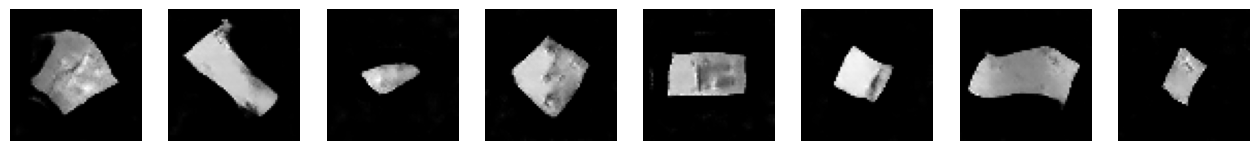

Epoch: 91	epoch time 0.37 min
	 d_loss: 0.2413 | g_loss: 5.1918 | d_real_acc: 0.9564 | d_fake_acc: 0.9651 | g_acc: 0.0349 | 
Epoch: 92	epoch time 0.37 min
	 d_loss: 0.2752 | g_loss: 5.1085 | d_real_acc: 0.9466 | d_fake_acc: 0.9528 | g_acc: 0.0472 | 
Epoch: 93	epoch time 0.37 min
	 d_loss: 0.2700 | g_loss: 5.2315 | d_real_acc: 0.9513 | d_fake_acc: 0.9611 | g_acc: 0.0389 | 
Epoch: 94	epoch time 0.37 min
	 d_loss: 0.2653 | g_loss: 5.2835 | d_real_acc: 0.9490 | d_fake_acc: 0.9636 | g_acc: 0.0364 | 
Epoch: 95	epoch time 0.37 min
	 d_loss: 0.2072 | g_loss: 5.2953 | d_real_acc: 0.9630 | d_fake_acc: 0.9668 | g_acc: 0.0332 | 
Epoch: 96	epoch time 0.37 min
	 d_loss: 0.3496 | g_loss: 5.0520 | d_real_acc: 0.9373 | d_fake_acc: 0.9436 | g_acc: 0.0564 | 
Epoch: 97	epoch time 0.37 min
	 d_loss: 0.2843 | g_loss: 5.1529 | d_real_acc: 0.9474 | d_fake_acc: 0.9590 | g_acc: 0.0410 | 
Epoch: 98	epoch time 0.37 min
	 d_loss: 0.3214 | g_loss: 5.0117 | d_real_acc: 0.9415 | d_fake_acc: 0.9531 | g_acc: 0.0469 | 


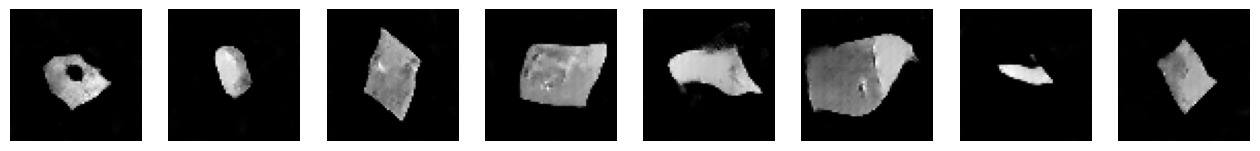

Epoch: 101	epoch time 0.38 min
	 d_loss: 0.2976 | g_loss: 5.0399 | d_real_acc: 0.9457 | d_fake_acc: 0.9553 | g_acc: 0.0448 | 
Epoch: 102	epoch time 0.39 min
	 d_loss: 0.2667 | g_loss: 5.2465 | d_real_acc: 0.9499 | d_fake_acc: 0.9603 | g_acc: 0.0397 | 
Epoch: 103	epoch time 0.40 min
	 d_loss: 0.2120 | g_loss: 5.2523 | d_real_acc: 0.9603 | d_fake_acc: 0.9699 | g_acc: 0.0301 | 
Epoch: 104	epoch time 0.40 min
	 d_loss: 0.2779 | g_loss: 5.1878 | d_real_acc: 0.9487 | d_fake_acc: 0.9556 | g_acc: 0.0444 | 
Epoch: 105	epoch time 0.40 min
	 d_loss: 0.1999 | g_loss: 5.3638 | d_real_acc: 0.9642 | d_fake_acc: 0.9686 | g_acc: 0.0314 | 
Epoch: 106	epoch time 0.40 min
	 d_loss: 0.3406 | g_loss: 5.2625 | d_real_acc: 0.9373 | d_fake_acc: 0.9500 | g_acc: 0.0500 | 
Epoch: 107	epoch time 0.40 min
	 d_loss: 0.3146 | g_loss: 5.1621 | d_real_acc: 0.9413 | d_fake_acc: 0.9555 | g_acc: 0.0445 | 
Epoch: 108	epoch time 0.38 min
	 d_loss: 0.2043 | g_loss: 5.3676 | d_real_acc: 0.9629 | d_fake_acc: 0.9725 | g_acc: 0.

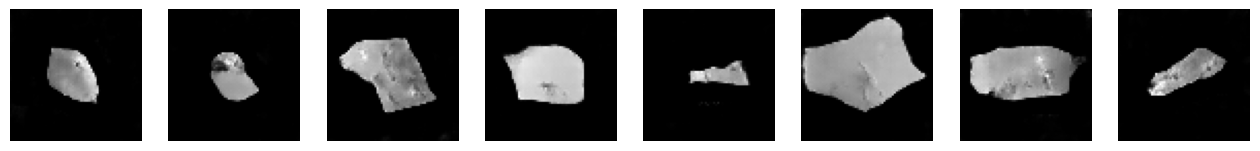

Epoch: 111	epoch time 0.37 min
	 d_loss: 0.2603 | g_loss: 5.3215 | d_real_acc: 0.9503 | d_fake_acc: 0.9621 | g_acc: 0.0379 | 
Epoch: 112	epoch time 0.39 min
	 d_loss: 0.2688 | g_loss: 5.4306 | d_real_acc: 0.9493 | d_fake_acc: 0.9598 | g_acc: 0.0402 | 
Epoch: 113	epoch time 0.38 min
	 d_loss: 0.2249 | g_loss: 5.4055 | d_real_acc: 0.9571 | d_fake_acc: 0.9570 | g_acc: 0.0430 | 
Epoch: 114	epoch time 0.38 min
	 d_loss: 0.2855 | g_loss: 5.3428 | d_real_acc: 0.9487 | d_fake_acc: 0.9559 | g_acc: 0.0441 | 
Epoch: 115	epoch time 0.37 min
	 d_loss: 0.2267 | g_loss: 5.3216 | d_real_acc: 0.9607 | d_fake_acc: 0.9681 | g_acc: 0.0319 | 
Epoch: 116	epoch time 0.37 min
	 d_loss: 0.2242 | g_loss: 5.5383 | d_real_acc: 0.9609 | d_fake_acc: 0.9673 | g_acc: 0.0327 | 
Epoch: 117	epoch time 0.38 min
	 d_loss: 0.2690 | g_loss: 5.5827 | d_real_acc: 0.9546 | d_fake_acc: 0.9640 | g_acc: 0.0360 | 
Epoch: 118	epoch time 0.38 min
	 d_loss: 0.3025 | g_loss: 5.3053 | d_real_acc: 0.9431 | d_fake_acc: 0.9590 | g_acc: 0.

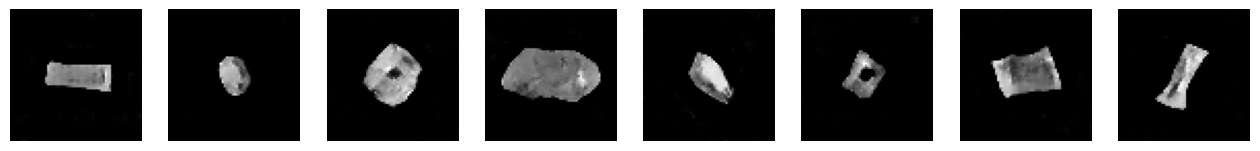

Epoch: 121	epoch time 0.37 min
	 d_loss: 0.2134 | g_loss: 5.4484 | d_real_acc: 0.9592 | d_fake_acc: 0.9653 | g_acc: 0.0347 | 
Epoch: 122	epoch time 0.38 min
	 d_loss: 0.3032 | g_loss: 5.3715 | d_real_acc: 0.9474 | d_fake_acc: 0.9591 | g_acc: 0.0409 | 
Epoch: 123	epoch time 0.38 min
	 d_loss: 0.2314 | g_loss: 5.4310 | d_real_acc: 0.9589 | d_fake_acc: 0.9600 | g_acc: 0.0400 | 
Epoch: 124	epoch time 0.39 min
	 d_loss: 0.2861 | g_loss: 5.3378 | d_real_acc: 0.9495 | d_fake_acc: 0.9549 | g_acc: 0.0451 | 
Epoch: 125	epoch time 0.38 min
	 d_loss: 0.2198 | g_loss: 5.4369 | d_real_acc: 0.9562 | d_fake_acc: 0.9633 | g_acc: 0.0366 | 
Epoch: 126	epoch time 0.38 min
	 d_loss: 0.2162 | g_loss: 5.4856 | d_real_acc: 0.9612 | d_fake_acc: 0.9622 | g_acc: 0.0378 | 
Epoch: 127	epoch time 0.39 min
	 d_loss: 0.3117 | g_loss: 5.3623 | d_real_acc: 0.9447 | d_fake_acc: 0.9554 | g_acc: 0.0446 | 
Epoch: 128	epoch time 0.39 min
	 d_loss: 0.2441 | g_loss: 5.5213 | d_real_acc: 0.9550 | d_fake_acc: 0.9650 | g_acc: 0.

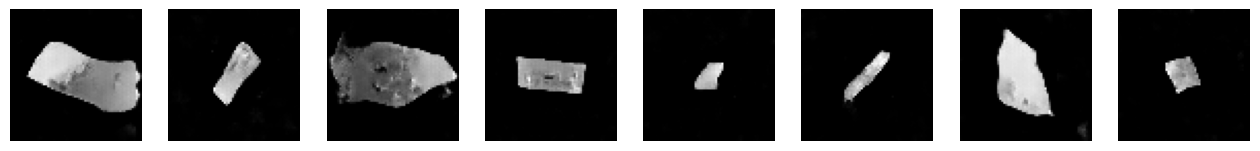

Epoch: 131	epoch time 0.37 min
	 d_loss: 0.2217 | g_loss: 5.6860 | d_real_acc: 0.9585 | d_fake_acc: 0.9635 | g_acc: 0.0365 | 
Epoch: 132	epoch time 0.37 min
	 d_loss: 0.2321 | g_loss: 5.7048 | d_real_acc: 0.9571 | d_fake_acc: 0.9689 | g_acc: 0.0312 | 
Epoch: 133	epoch time 0.37 min
	 d_loss: 0.2439 | g_loss: 5.4869 | d_real_acc: 0.9520 | d_fake_acc: 0.9653 | g_acc: 0.0347 | 
Epoch: 134	epoch time 0.37 min
	 d_loss: 0.2947 | g_loss: 5.2962 | d_real_acc: 0.9462 | d_fake_acc: 0.9530 | g_acc: 0.0470 | 
Epoch: 135	epoch time 0.37 min
	 d_loss: 0.2457 | g_loss: 5.5518 | d_real_acc: 0.9550 | d_fake_acc: 0.9703 | g_acc: 0.0297 | 
Epoch: 136	epoch time 0.38 min
	 d_loss: 0.2303 | g_loss: 5.4665 | d_real_acc: 0.9550 | d_fake_acc: 0.9655 | g_acc: 0.0345 | 
Epoch: 137	epoch time 0.37 min
	 d_loss: 0.2825 | g_loss: 5.6084 | d_real_acc: 0.9470 | d_fake_acc: 0.9585 | g_acc: 0.0415 | 
Epoch: 138	epoch time 0.38 min
	 d_loss: 0.2262 | g_loss: 5.4733 | d_real_acc: 0.9596 | d_fake_acc: 0.9629 | g_acc: 0.

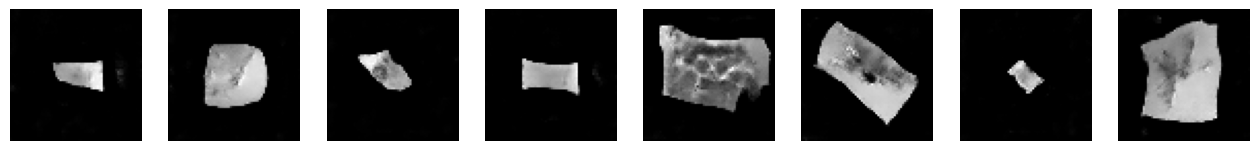

Epoch: 141	epoch time 0.38 min
	 d_loss: 0.2575 | g_loss: 5.6144 | d_real_acc: 0.9551 | d_fake_acc: 0.9591 | g_acc: 0.0409 | 
Epoch: 142	epoch time 0.39 min
	 d_loss: 0.2361 | g_loss: 5.5823 | d_real_acc: 0.9576 | d_fake_acc: 0.9677 | g_acc: 0.0323 | 
Epoch: 143	epoch time 0.38 min
	 d_loss: 0.2721 | g_loss: 5.4039 | d_real_acc: 0.9506 | d_fake_acc: 0.9552 | g_acc: 0.0448 | 
Epoch: 144	epoch time 0.38 min
	 d_loss: 0.1967 | g_loss: 5.6903 | d_real_acc: 0.9659 | d_fake_acc: 0.9726 | g_acc: 0.0274 | 
Epoch: 145	epoch time 0.38 min
	 d_loss: 0.2069 | g_loss: 5.6751 | d_real_acc: 0.9606 | d_fake_acc: 0.9655 | g_acc: 0.0345 | 
Epoch: 146	epoch time 0.38 min
	 d_loss: 0.2705 | g_loss: 5.7557 | d_real_acc: 0.9510 | d_fake_acc: 0.9632 | g_acc: 0.0368 | 
Epoch: 147	epoch time 0.39 min
	 d_loss: 0.1875 | g_loss: 5.7499 | d_real_acc: 0.9684 | d_fake_acc: 0.9728 | g_acc: 0.0272 | 
Epoch: 148	epoch time 0.38 min
	 d_loss: 0.2829 | g_loss: 5.7927 | d_real_acc: 0.9492 | d_fake_acc: 0.9620 | g_acc: 0.

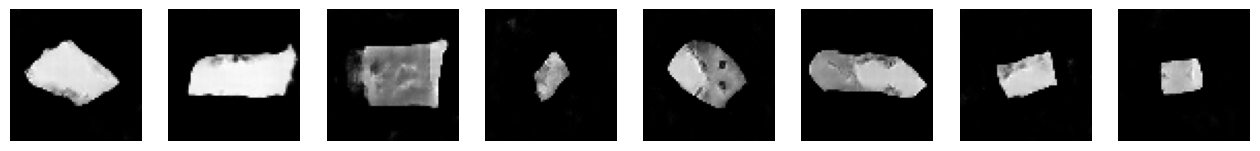

Epoch: 151	epoch time 0.39 min
	 d_loss: 0.2163 | g_loss: 5.5883 | d_real_acc: 0.9613 | d_fake_acc: 0.9699 | g_acc: 0.0301 | 
Epoch: 152	epoch time 0.38 min
	 d_loss: 0.1684 | g_loss: 5.8965 | d_real_acc: 0.9696 | d_fake_acc: 0.9724 | g_acc: 0.0277 | 
Epoch: 153	epoch time 0.38 min
	 d_loss: 0.2322 | g_loss: 5.7603 | d_real_acc: 0.9557 | d_fake_acc: 0.9636 | g_acc: 0.0364 | 
Epoch: 154	epoch time 0.38 min
	 d_loss: 0.2335 | g_loss: 5.6382 | d_real_acc: 0.9580 | d_fake_acc: 0.9610 | g_acc: 0.0390 | 
Epoch: 155	epoch time 0.38 min
	 d_loss: 0.2112 | g_loss: 5.7851 | d_real_acc: 0.9631 | d_fake_acc: 0.9745 | g_acc: 0.0255 | 
Epoch: 156	epoch time 0.38 min
	 d_loss: 0.2378 | g_loss: 5.8083 | d_real_acc: 0.9565 | d_fake_acc: 0.9687 | g_acc: 0.0313 | 
Epoch: 157	epoch time 0.38 min
	 d_loss: 0.2159 | g_loss: 5.6884 | d_real_acc: 0.9596 | d_fake_acc: 0.9645 | g_acc: 0.0355 | 
Epoch: 158	epoch time 0.38 min
	 d_loss: 0.2716 | g_loss: 5.7816 | d_real_acc: 0.9538 | d_fake_acc: 0.9655 | g_acc: 0.

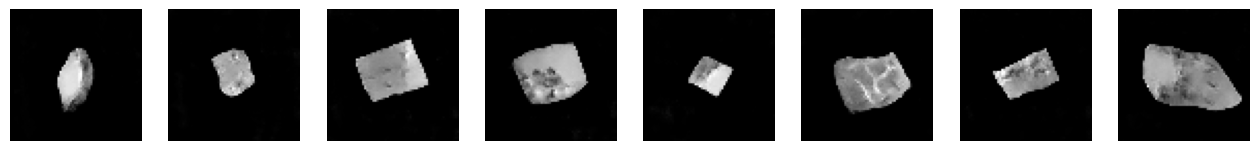

Epoch: 161	epoch time 0.39 min
	 d_loss: 0.2283 | g_loss: 5.7719 | d_real_acc: 0.9615 | d_fake_acc: 0.9722 | g_acc: 0.0278 | 
Epoch: 162	epoch time 0.39 min
	 d_loss: 0.1628 | g_loss: 5.7583 | d_real_acc: 0.9696 | d_fake_acc: 0.9757 | g_acc: 0.0243 | 
Epoch: 163	epoch time 0.38 min
	 d_loss: 0.2600 | g_loss: 5.7004 | d_real_acc: 0.9557 | d_fake_acc: 0.9650 | g_acc: 0.0350 | 
Epoch: 164	epoch time 0.39 min
	 d_loss: 0.2317 | g_loss: 5.9682 | d_real_acc: 0.9561 | d_fake_acc: 0.9705 | g_acc: 0.0295 | 
Epoch: 165	epoch time 0.39 min
	 d_loss: 0.1892 | g_loss: 5.9285 | d_real_acc: 0.9655 | d_fake_acc: 0.9741 | g_acc: 0.0259 | 
Epoch: 166	epoch time 0.39 min
	 d_loss: 0.1636 | g_loss: 5.8492 | d_real_acc: 0.9681 | d_fake_acc: 0.9756 | g_acc: 0.0244 | 
Epoch: 167	epoch time 0.38 min
	 d_loss: 0.2166 | g_loss: 5.9120 | d_real_acc: 0.9630 | d_fake_acc: 0.9710 | g_acc: 0.0290 | 
Epoch: 168	epoch time 0.38 min
	 d_loss: 0.2286 | g_loss: 5.9659 | d_real_acc: 0.9579 | d_fake_acc: 0.9671 | g_acc: 0.

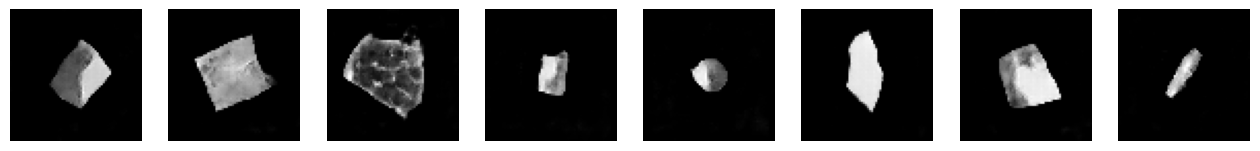

Epoch: 171	epoch time 0.38 min
	 d_loss: 0.1651 | g_loss: 5.9476 | d_real_acc: 0.9706 | d_fake_acc: 0.9766 | g_acc: 0.0234 | 
Epoch: 172	epoch time 0.38 min
	 d_loss: 0.1616 | g_loss: 5.9159 | d_real_acc: 0.9712 | d_fake_acc: 0.9794 | g_acc: 0.0205 | 
Epoch: 173	epoch time 0.38 min
	 d_loss: 0.2976 | g_loss: 5.7861 | d_real_acc: 0.9473 | d_fake_acc: 0.9483 | g_acc: 0.0517 | 
Epoch: 174	epoch time 0.37 min
	 d_loss: 0.1660 | g_loss: 6.0477 | d_real_acc: 0.9694 | d_fake_acc: 0.9807 | g_acc: 0.0193 | 
Epoch: 175	epoch time 0.38 min
	 d_loss: 0.2184 | g_loss: 6.0746 | d_real_acc: 0.9614 | d_fake_acc: 0.9704 | g_acc: 0.0296 | 
Epoch: 176	epoch time 0.38 min
	 d_loss: 0.1827 | g_loss: 6.0876 | d_real_acc: 0.9657 | d_fake_acc: 0.9712 | g_acc: 0.0288 | 
Epoch: 177	epoch time 0.38 min
	 d_loss: 0.2203 | g_loss: 6.0641 | d_real_acc: 0.9602 | d_fake_acc: 0.9686 | g_acc: 0.0314 | 
Epoch: 178	epoch time 0.39 min
	 d_loss: 0.1914 | g_loss: 6.0645 | d_real_acc: 0.9632 | d_fake_acc: 0.9679 | g_acc: 0.

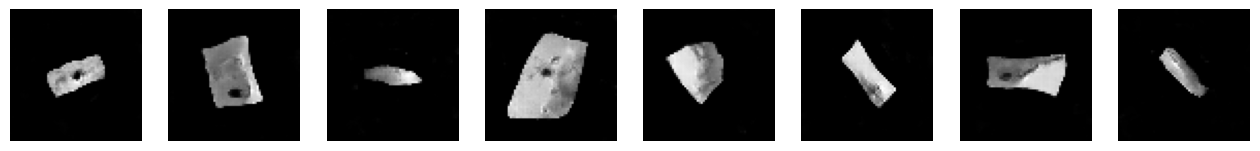

Epoch: 181	epoch time 0.38 min
	 d_loss: 0.2054 | g_loss: 6.0725 | d_real_acc: 0.9630 | d_fake_acc: 0.9777 | g_acc: 0.0223 | 
Epoch: 182	epoch time 0.37 min
	 d_loss: 0.2155 | g_loss: 5.8868 | d_real_acc: 0.9631 | d_fake_acc: 0.9713 | g_acc: 0.0287 | 
Epoch: 183	epoch time 0.37 min
	 d_loss: 0.2256 | g_loss: 5.9430 | d_real_acc: 0.9571 | d_fake_acc: 0.9669 | g_acc: 0.0331 | 
Epoch: 184	epoch time 0.38 min
	 d_loss: 0.1242 | g_loss: 6.1520 | d_real_acc: 0.9750 | d_fake_acc: 0.9811 | g_acc: 0.0189 | 
Epoch: 185	epoch time 0.38 min
	 d_loss: 0.1811 | g_loss: 6.1141 | d_real_acc: 0.9688 | d_fake_acc: 0.9739 | g_acc: 0.0261 | 
Epoch: 186	epoch time 0.38 min
	 d_loss: 0.2549 | g_loss: 6.0561 | d_real_acc: 0.9587 | d_fake_acc: 0.9679 | g_acc: 0.0321 | 
Epoch: 187	epoch time 0.38 min
	 d_loss: 0.2102 | g_loss: 6.0500 | d_real_acc: 0.9632 | d_fake_acc: 0.9738 | g_acc: 0.0262 | 
Epoch: 188	epoch time 0.38 min
	 d_loss: 0.1863 | g_loss: 6.0672 | d_real_acc: 0.9664 | d_fake_acc: 0.9753 | g_acc: 0.

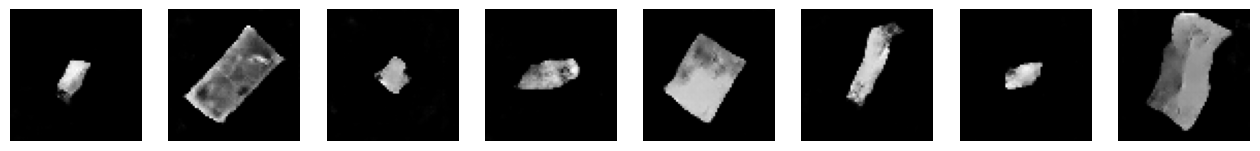

Epoch: 191	epoch time 0.39 min
	 d_loss: 0.2547 | g_loss: 5.7446 | d_real_acc: 0.9539 | d_fake_acc: 0.9602 | g_acc: 0.0399 | 
Epoch: 192	epoch time 0.38 min
	 d_loss: 0.1677 | g_loss: 6.1504 | d_real_acc: 0.9720 | d_fake_acc: 0.9774 | g_acc: 0.0226 | 
Epoch: 193	epoch time 0.38 min
	 d_loss: 0.2437 | g_loss: 6.0484 | d_real_acc: 0.9556 | d_fake_acc: 0.9613 | g_acc: 0.0388 | 
Epoch: 194	epoch time 0.36 min
	 d_loss: 0.1350 | g_loss: 6.0062 | d_real_acc: 0.9788 | d_fake_acc: 0.9813 | g_acc: 0.0187 | 
Epoch: 195	epoch time 0.40 min
	 d_loss: 0.2265 | g_loss: 6.0448 | d_real_acc: 0.9614 | d_fake_acc: 0.9703 | g_acc: 0.0298 | 
Epoch: 196	epoch time 0.40 min
	 d_loss: 0.2374 | g_loss: 6.0961 | d_real_acc: 0.9597 | d_fake_acc: 0.9641 | g_acc: 0.0359 | 
Epoch: 197	epoch time 0.40 min
	 d_loss: 0.1593 | g_loss: 5.9672 | d_real_acc: 0.9732 | d_fake_acc: 0.9765 | g_acc: 0.0235 | 
Epoch: 198	epoch time 0.40 min
	 d_loss: 0.1421 | g_loss: 6.2341 | d_real_acc: 0.9765 | d_fake_acc: 0.9822 | g_acc: 0.

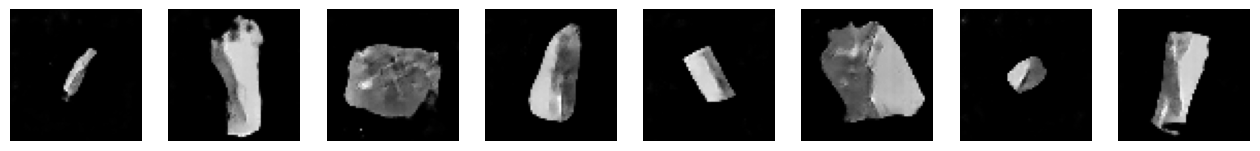

Epoch: 201	epoch time 0.40 min
	 d_loss: 0.1755 | g_loss: 6.1621 | d_real_acc: 0.9675 | d_fake_acc: 0.9762 | g_acc: 0.0238 | 
Epoch: 202	epoch time 0.39 min
	 d_loss: 0.1413 | g_loss: 6.2185 | d_real_acc: 0.9754 | d_fake_acc: 0.9760 | g_acc: 0.0240 | 
Epoch: 203	epoch time 0.40 min
	 d_loss: 0.2428 | g_loss: 6.2261 | d_real_acc: 0.9582 | d_fake_acc: 0.9650 | g_acc: 0.0350 | 
Epoch: 204	epoch time 532.35 min
	 d_loss: 0.1979 | g_loss: 6.1751 | d_real_acc: 0.9639 | d_fake_acc: 0.9719 | g_acc: 0.0281 | 
Epoch: 205	epoch time 0.40 min
	 d_loss: 0.2054 | g_loss: 6.2734 | d_real_acc: 0.9672 | d_fake_acc: 0.9709 | g_acc: 0.0291 | 
Epoch: 206	epoch time 0.38 min
	 d_loss: 0.1875 | g_loss: 6.3649 | d_real_acc: 0.9677 | d_fake_acc: 0.9727 | g_acc: 0.0273 | 
Epoch: 207	epoch time 0.39 min
	 d_loss: 0.2052 | g_loss: 5.9493 | d_real_acc: 0.9664 | d_fake_acc: 0.9710 | g_acc: 0.0290 | 
Epoch: 208	epoch time 0.39 min
	 d_loss: 0.1929 | g_loss: 6.2498 | d_real_acc: 0.9654 | d_fake_acc: 0.9722 | g_acc: 

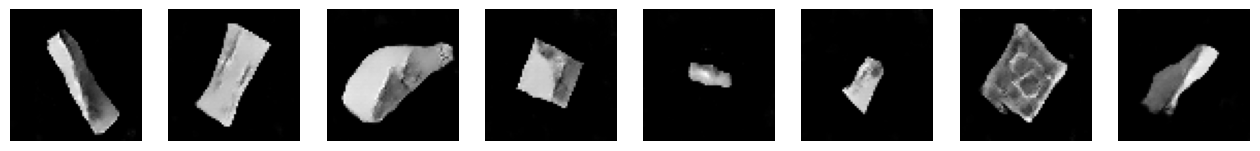

Epoch: 211	epoch time 0.38 min
	 d_loss: 0.2142 | g_loss: 6.5147 | d_real_acc: 0.9696 | d_fake_acc: 0.9743 | g_acc: 0.0257 | 
Epoch: 212	epoch time 0.38 min
	 d_loss: 0.2272 | g_loss: 5.9685 | d_real_acc: 0.9577 | d_fake_acc: 0.9692 | g_acc: 0.0308 | 
Epoch: 213	epoch time 0.38 min
	 d_loss: 0.1809 | g_loss: 6.2743 | d_real_acc: 0.9673 | d_fake_acc: 0.9774 | g_acc: 0.0226 | 
Epoch: 214	epoch time 0.38 min
	 d_loss: 0.1870 | g_loss: 6.1543 | d_real_acc: 0.9670 | d_fake_acc: 0.9739 | g_acc: 0.0261 | 
Epoch: 215	epoch time 0.38 min
	 d_loss: 0.1392 | g_loss: 6.3702 | d_real_acc: 0.9750 | d_fake_acc: 0.9772 | g_acc: 0.0227 | 
Epoch: 216	epoch time 0.38 min
	 d_loss: 0.1559 | g_loss: 6.5375 | d_real_acc: 0.9732 | d_fake_acc: 0.9819 | g_acc: 0.0181 | 
Epoch: 217	epoch time 0.39 min
	 d_loss: 0.1905 | g_loss: 6.2434 | d_real_acc: 0.9648 | d_fake_acc: 0.9716 | g_acc: 0.0284 | 
Epoch: 218	epoch time 0.38 min
	 d_loss: 0.2227 | g_loss: 6.0635 | d_real_acc: 0.9607 | d_fake_acc: 0.9645 | g_acc: 0.

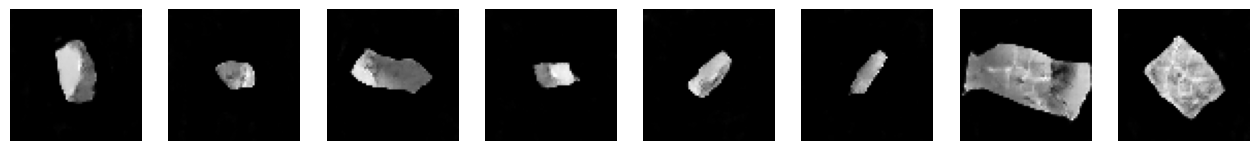

Epoch: 221	epoch time 0.38 min
	 d_loss: 0.1785 | g_loss: 6.2034 | d_real_acc: 0.9707 | d_fake_acc: 0.9771 | g_acc: 0.0229 | 
Epoch: 222	epoch time 0.37 min
	 d_loss: 0.1801 | g_loss: 6.1898 | d_real_acc: 0.9694 | d_fake_acc: 0.9718 | g_acc: 0.0282 | 
Epoch: 223	epoch time 0.37 min
	 d_loss: 0.1947 | g_loss: 6.3917 | d_real_acc: 0.9647 | d_fake_acc: 0.9691 | g_acc: 0.0309 | 
Epoch: 224	epoch time 0.38 min
	 d_loss: 0.1543 | g_loss: 6.3901 | d_real_acc: 0.9728 | d_fake_acc: 0.9760 | g_acc: 0.0240 | 
Epoch: 225	epoch time 0.42 min
	 d_loss: 0.2135 | g_loss: 6.2515 | d_real_acc: 0.9629 | d_fake_acc: 0.9681 | g_acc: 0.0319 | 
Epoch: 226	epoch time 0.39 min
	 d_loss: 0.1356 | g_loss: 6.2113 | d_real_acc: 0.9783 | d_fake_acc: 0.9804 | g_acc: 0.0196 | 
Epoch: 227	epoch time 0.39 min
	 d_loss: 0.2597 | g_loss: 6.2845 | d_real_acc: 0.9567 | d_fake_acc: 0.9655 | g_acc: 0.0345 | 
Epoch: 228	epoch time 0.40 min
	 d_loss: 0.1928 | g_loss: 6.1736 | d_real_acc: 0.9676 | d_fake_acc: 0.9721 | g_acc: 0.

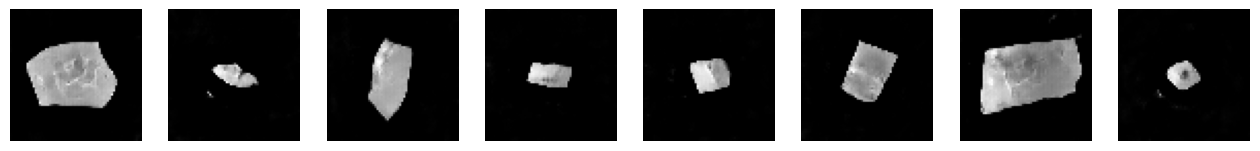

Epoch: 231	epoch time 0.38 min
	 d_loss: 0.2069 | g_loss: 6.2233 | d_real_acc: 0.9674 | d_fake_acc: 0.9761 | g_acc: 0.0239 | 
Epoch: 232	epoch time 0.37 min
	 d_loss: 0.1522 | g_loss: 6.2924 | d_real_acc: 0.9736 | d_fake_acc: 0.9748 | g_acc: 0.0251 | 
Epoch: 233	epoch time 0.39 min
	 d_loss: 0.2330 | g_loss: 6.2960 | d_real_acc: 0.9582 | d_fake_acc: 0.9718 | g_acc: 0.0282 | 
Epoch: 234	epoch time 0.38 min
	 d_loss: 0.1184 | g_loss: 6.2842 | d_real_acc: 0.9790 | d_fake_acc: 0.9830 | g_acc: 0.0170 | 
Epoch: 235	epoch time 0.38 min
	 d_loss: 0.2425 | g_loss: 6.0454 | d_real_acc: 0.9597 | d_fake_acc: 0.9669 | g_acc: 0.0331 | 
Epoch: 236	epoch time 0.39 min
	 d_loss: 0.2264 | g_loss: 6.2508 | d_real_acc: 0.9587 | d_fake_acc: 0.9660 | g_acc: 0.0340 | 
Epoch: 237	epoch time 0.39 min
	 d_loss: 0.1265 | g_loss: 6.2863 | d_real_acc: 0.9800 | d_fake_acc: 0.9815 | g_acc: 0.0184 | 
Epoch: 238	epoch time 0.39 min
	 d_loss: 0.1771 | g_loss: 6.3297 | d_real_acc: 0.9669 | d_fake_acc: 0.9765 | g_acc: 0.

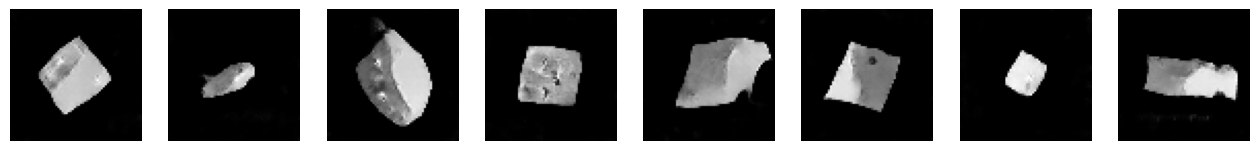

Epoch: 241	epoch time 0.38 min
	 d_loss: 0.1144 | g_loss: 6.5027 | d_real_acc: 0.9799 | d_fake_acc: 0.9818 | g_acc: 0.0182 | 
Epoch: 242	epoch time 0.39 min
	 d_loss: 0.1806 | g_loss: 6.3171 | d_real_acc: 0.9670 | d_fake_acc: 0.9699 | g_acc: 0.0301 | 
Epoch: 243	epoch time 0.39 min
	 d_loss: 0.1982 | g_loss: 6.4440 | d_real_acc: 0.9718 | d_fake_acc: 0.9740 | g_acc: 0.0260 | 
Epoch: 244	epoch time 0.39 min
	 d_loss: 0.1824 | g_loss: 6.2804 | d_real_acc: 0.9687 | d_fake_acc: 0.9750 | g_acc: 0.0250 | 
Epoch: 245	epoch time 0.38 min
	 d_loss: 0.1979 | g_loss: 6.3937 | d_real_acc: 0.9628 | d_fake_acc: 0.9683 | g_acc: 0.0317 | 
Epoch: 246	epoch time 0.38 min
	 d_loss: 0.1693 | g_loss: 6.5326 | d_real_acc: 0.9674 | d_fake_acc: 0.9738 | g_acc: 0.0262 | 
Epoch: 247	epoch time 0.37 min
	 d_loss: 0.1900 | g_loss: 6.3721 | d_real_acc: 0.9671 | d_fake_acc: 0.9755 | g_acc: 0.0245 | 
Epoch: 248	epoch time 0.39 min
	 d_loss: 0.1541 | g_loss: 6.5209 | d_real_acc: 0.9727 | d_fake_acc: 0.9821 | g_acc: 0.

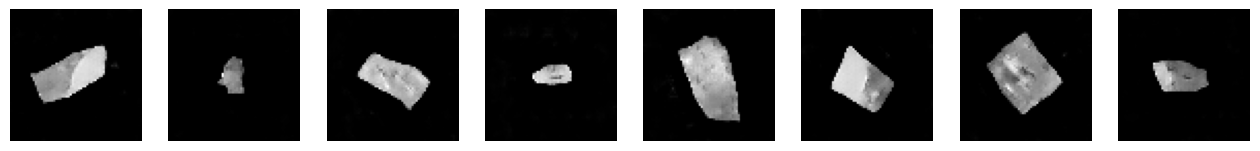

Epoch: 251	epoch time 0.38 min
	 d_loss: 0.1302 | g_loss: 6.3495 | d_real_acc: 0.9774 | d_fake_acc: 0.9799 | g_acc: 0.0201 | 
Epoch: 252	epoch time 0.38 min
	 d_loss: 0.1434 | g_loss: 6.4341 | d_real_acc: 0.9749 | d_fake_acc: 0.9818 | g_acc: 0.0182 | 
Epoch: 253	epoch time 0.38 min
	 d_loss: 0.2062 | g_loss: 6.3131 | d_real_acc: 0.9673 | d_fake_acc: 0.9725 | g_acc: 0.0275 | 
Epoch: 254	epoch time 0.38 min
	 d_loss: 0.1648 | g_loss: 6.3050 | d_real_acc: 0.9722 | d_fake_acc: 0.9817 | g_acc: 0.0183 | 
Epoch: 255	epoch time 0.38 min
	 d_loss: 0.1687 | g_loss: 6.3919 | d_real_acc: 0.9725 | d_fake_acc: 0.9763 | g_acc: 0.0237 | 
Epoch: 256	epoch time 0.38 min
	 d_loss: 0.1630 | g_loss: 6.3487 | d_real_acc: 0.9746 | d_fake_acc: 0.9782 | g_acc: 0.0218 | 
Epoch: 257	epoch time 0.38 min
	 d_loss: 0.1028 | g_loss: 6.4756 | d_real_acc: 0.9810 | d_fake_acc: 0.9833 | g_acc: 0.0167 | 
Epoch: 258	epoch time 0.39 min
	 d_loss: 0.2254 | g_loss: 6.4904 | d_real_acc: 0.9625 | d_fake_acc: 0.9701 | g_acc: 0.

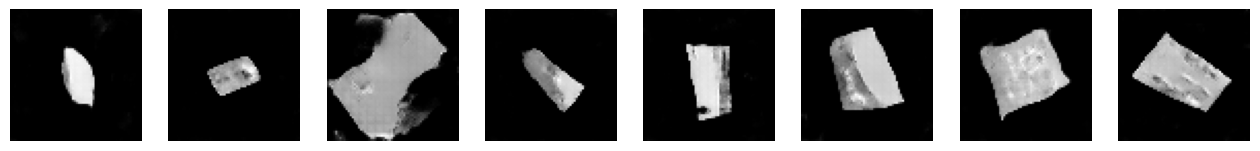

Epoch: 261	epoch time 0.37 min
	 d_loss: 0.1851 | g_loss: 6.0354 | d_real_acc: 0.9675 | d_fake_acc: 0.9714 | g_acc: 0.0286 | 
Epoch: 262	epoch time 0.37 min
	 d_loss: 0.2187 | g_loss: 6.1903 | d_real_acc: 0.9644 | d_fake_acc: 0.9701 | g_acc: 0.0299 | 
Epoch: 263	epoch time 0.37 min
	 d_loss: 0.1228 | g_loss: 6.3343 | d_real_acc: 0.9809 | d_fake_acc: 0.9810 | g_acc: 0.0190 | 
Epoch: 264	epoch time 0.37 min
	 d_loss: 0.1709 | g_loss: 6.5491 | d_real_acc: 0.9726 | d_fake_acc: 0.9777 | g_acc: 0.0223 | 
Epoch: 265	epoch time 0.39 min
	 d_loss: 0.2343 | g_loss: 6.1547 | d_real_acc: 0.9575 | d_fake_acc: 0.9707 | g_acc: 0.0293 | 
Epoch: 266	epoch time 0.39 min
	 d_loss: 0.1213 | g_loss: 6.1469 | d_real_acc: 0.9791 | d_fake_acc: 0.9790 | g_acc: 0.0210 | 
Epoch: 267	epoch time 0.40 min
	 d_loss: 0.1285 | g_loss: 6.3326 | d_real_acc: 0.9767 | d_fake_acc: 0.9791 | g_acc: 0.0209 | 
Epoch: 268	epoch time 0.40 min
	 d_loss: 0.2280 | g_loss: 6.5102 | d_real_acc: 0.9631 | d_fake_acc: 0.9779 | g_acc: 0.

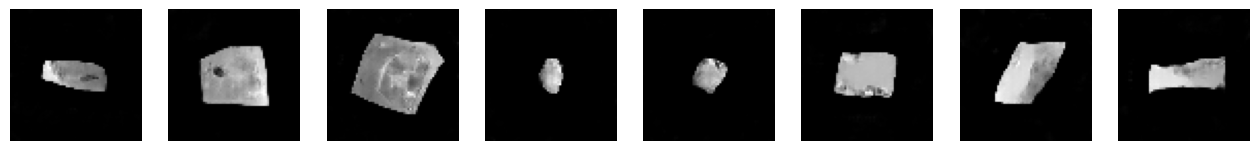

Epoch: 271	epoch time 0.38 min
	 d_loss: 0.1283 | g_loss: 6.3511 | d_real_acc: 0.9783 | d_fake_acc: 0.9817 | g_acc: 0.0183 | 
Epoch: 272	epoch time 0.38 min
	 d_loss: 0.2453 | g_loss: 6.4083 | d_real_acc: 0.9546 | d_fake_acc: 0.9700 | g_acc: 0.0300 | 
Epoch: 273	epoch time 0.39 min
	 d_loss: 0.1307 | g_loss: 6.5033 | d_real_acc: 0.9787 | d_fake_acc: 0.9833 | g_acc: 0.0167 | 
Epoch: 274	epoch time 0.39 min
	 d_loss: 0.1236 | g_loss: 6.5095 | d_real_acc: 0.9787 | d_fake_acc: 0.9811 | g_acc: 0.0189 | 
Epoch: 275	epoch time 0.38 min
	 d_loss: 0.1665 | g_loss: 6.4930 | d_real_acc: 0.9694 | d_fake_acc: 0.9754 | g_acc: 0.0246 | 
Epoch: 276	epoch time 0.38 min
	 d_loss: 0.1507 | g_loss: 6.7630 | d_real_acc: 0.9764 | d_fake_acc: 0.9842 | g_acc: 0.0158 | 
Epoch: 277	epoch time 0.39 min
	 d_loss: 0.1589 | g_loss: 6.7063 | d_real_acc: 0.9693 | d_fake_acc: 0.9788 | g_acc: 0.0212 | 
Epoch: 278	epoch time 0.38 min
	 d_loss: 0.1394 | g_loss: 6.6505 | d_real_acc: 0.9767 | d_fake_acc: 0.9820 | g_acc: 0.

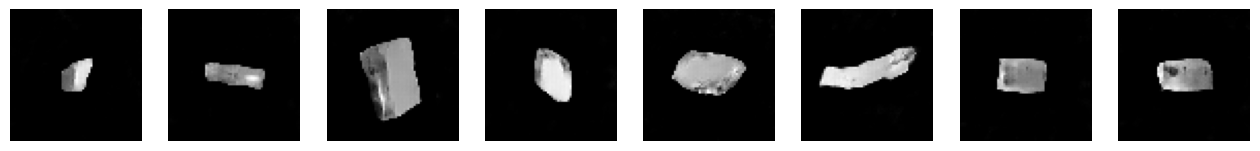

Epoch: 281	epoch time 0.39 min
	 d_loss: 0.1606 | g_loss: 6.4065 | d_real_acc: 0.9756 | d_fake_acc: 0.9780 | g_acc: 0.0220 | 
Epoch: 282	epoch time 0.39 min
	 d_loss: 0.1482 | g_loss: 6.3366 | d_real_acc: 0.9741 | d_fake_acc: 0.9759 | g_acc: 0.0241 | 
Epoch: 283	epoch time 0.38 min
	 d_loss: 0.1486 | g_loss: 6.5220 | d_real_acc: 0.9724 | d_fake_acc: 0.9772 | g_acc: 0.0228 | 
Epoch: 284	epoch time 0.39 min
	 d_loss: 0.1605 | g_loss: 6.6131 | d_real_acc: 0.9741 | d_fake_acc: 0.9758 | g_acc: 0.0242 | 
Epoch: 285	epoch time 0.39 min
	 d_loss: 0.1829 | g_loss: 6.3520 | d_real_acc: 0.9689 | d_fake_acc: 0.9754 | g_acc: 0.0246 | 
Epoch: 286	epoch time 0.38 min
	 d_loss: 0.1438 | g_loss: 6.6638 | d_real_acc: 0.9764 | d_fake_acc: 0.9785 | g_acc: 0.0215 | 
Epoch: 287	epoch time 0.39 min
	 d_loss: 0.0879 | g_loss: 6.7421 | d_real_acc: 0.9836 | d_fake_acc: 0.9872 | g_acc: 0.0128 | 
Epoch: 288	epoch time 0.38 min
	 d_loss: 0.1642 | g_loss: 6.7826 | d_real_acc: 0.9730 | d_fake_acc: 0.9793 | g_acc: 0.

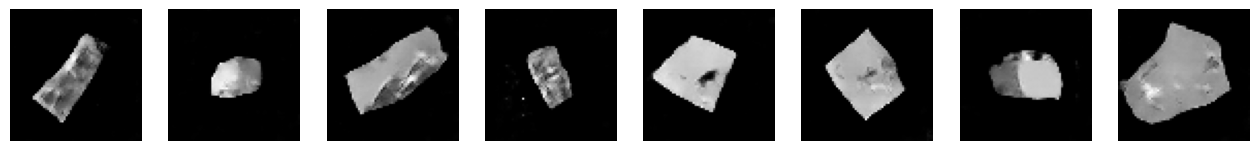

Epoch: 291	epoch time 0.38 min
	 d_loss: 0.1886 | g_loss: 6.5719 | d_real_acc: 0.9655 | d_fake_acc: 0.9710 | g_acc: 0.0290 | 
Epoch: 292	epoch time 0.38 min
	 d_loss: 0.2055 | g_loss: 6.7521 | d_real_acc: 0.9653 | d_fake_acc: 0.9755 | g_acc: 0.0245 | 
Epoch: 293	epoch time 0.37 min
	 d_loss: 0.1580 | g_loss: 6.4586 | d_real_acc: 0.9714 | d_fake_acc: 0.9772 | g_acc: 0.0228 | 
Epoch: 294	epoch time 0.38 min
	 d_loss: 0.0970 | g_loss: 6.9046 | d_real_acc: 0.9828 | d_fake_acc: 0.9837 | g_acc: 0.0163 | 
Epoch: 295	epoch time 0.38 min
	 d_loss: 0.1442 | g_loss: 6.7003 | d_real_acc: 0.9796 | d_fake_acc: 0.9818 | g_acc: 0.0182 | 
Epoch: 296	epoch time 0.38 min
	 d_loss: 0.1403 | g_loss: 6.9886 | d_real_acc: 0.9758 | d_fake_acc: 0.9805 | g_acc: 0.0195 | 
Epoch: 297	epoch time 0.38 min
	 d_loss: 0.1342 | g_loss: 6.7048 | d_real_acc: 0.9748 | d_fake_acc: 0.9785 | g_acc: 0.0215 | 
Epoch: 298	epoch time 0.38 min
	 d_loss: 0.1800 | g_loss: 6.7738 | d_real_acc: 0.9710 | d_fake_acc: 0.9780 | g_acc: 0.

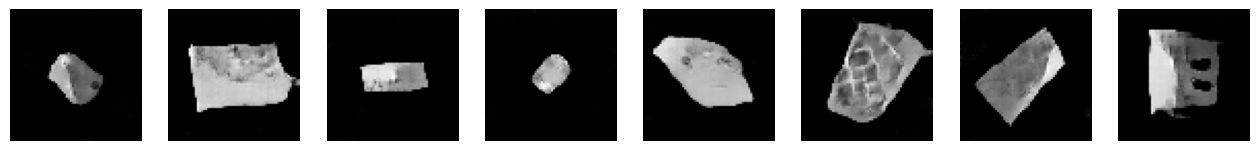

In [13]:
history = defaultdict(list)

for i in range(EPOCHS):
    prev_time = time.time()
    generated_imgs = train(net_D, net_G, lego_dataloader, d_optim, g_optim, loss_fn, train_metrics)
    curr_time = time.time()
    
    for key, value in train_metrics.items():
        history[key].append(value.compute().item())
    
    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item():.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))

    if i == 0 or (i + 1) % 10 == 0:
        generated_imgs = generated_imgs.detach().cpu()
        display_imgs(generated_imgs)

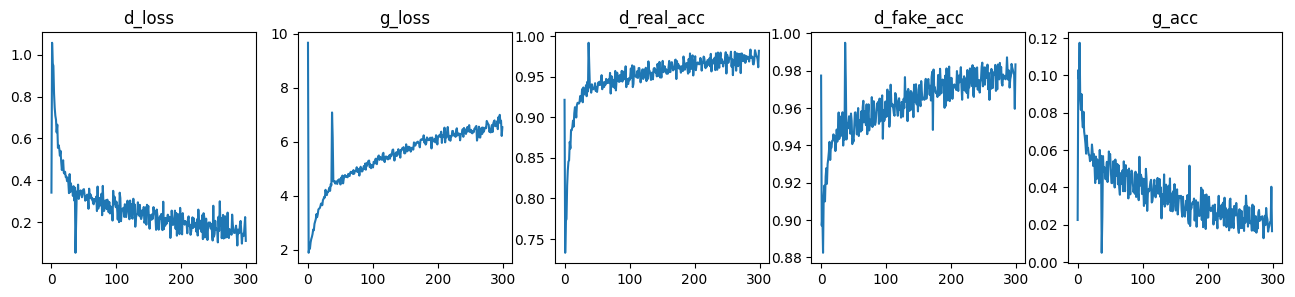

In [16]:
plt.figure(figsize=(16, 3))
for i, key in enumerate(history):
    ax = plt.subplot(1, len(history), i+1)
    # ax.imshow(imgs[i][0], cmap='gray')
    ax.plot(history[key])
    ax.set_title(key)
plt.show()